In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np

In [29]:
# --- Load Data ---
embeddings = np.load("virchow_embeds/patch_to_expr_NCBI783_embeddings.npy")
metadata = np.load("virchow_embeds/patch_to_expr_NCBI783_metadata.npy", allow_pickle=True)
expr = np.stack([m[3] for m in metadata])

In [30]:
# Convert to torch tensors
X = torch.tensor(embeddings, dtype=torch.float32)
Y = torch.tensor(expr, dtype=torch.float32)

In [31]:
# Dataset and DataLoader
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [32]:
import torch.nn as nn

class MLPRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=512):
        super(MLPRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()   # Add ReLU here
        )
    def forward(self, x):
        return self.net(x)


In [33]:
# ---------------------------
# 3. Safe Pearson Correlation
# ---------------------------
def pearson_corr(y_true, y_pred):
    corrs = []
    for i in range(y_true.shape[1]):
        std_true = np.std(y_true[:, i])
        std_pred = np.std(y_pred[:, i])
        if std_true == 0 or std_pred == 0:
            corr = np.nan
        else:
            corr, _ = pearsonr(y_true[:, i], y_pred[:, i])
        corrs.append(corr)
    return np.nanmean(corrs), corrs

In [34]:
# --- Model ---
input_dim = X.shape[1]
output_dim = Y.shape[1]
model = MLPRegressor(input_dim=input_dim, output_dim=output_dim, hidden_dim=512)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
# --- Optimizer and Loss ---
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [36]:
# --- Training ---
n_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
# ---------------------------
# 7. Training Loop
# ---------------------------
n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)

    avg_loss = epoch_loss / len(dataset)

    # Validation metrics
    model.eval()
    with torch.no_grad():
        y_pred = []
        y_true = []
        for xb, yb in loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            y_pred.append(preds)
            y_true.append(yb.numpy())

        y_pred = np.vstack(y_pred)
        y_true = np.vstack(y_true)
        mean_pearson, per_gene_corrs = pearson_corr(y_true, y_pred)

    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f} - Mean Pearson: {mean_pearson:.4f}")

Epoch 1/20 - Loss: 781.2106 - Mean Pearson: 0.6434
Epoch 2/20 - Loss: 327.8448 - Mean Pearson: 0.6896
Epoch 3/20 - Loss: 261.7724 - Mean Pearson: 0.6820
Epoch 4/20 - Loss: 239.3463 - Mean Pearson: 0.7453
Epoch 5/20 - Loss: 227.2674 - Mean Pearson: 0.7397
Epoch 6/20 - Loss: 220.7098 - Mean Pearson: 0.7600
Epoch 7/20 - Loss: 214.7134 - Mean Pearson: 0.7675
Epoch 8/20 - Loss: 208.3544 - Mean Pearson: 0.7831
Epoch 9/20 - Loss: 204.9222 - Mean Pearson: 0.7841
Epoch 10/20 - Loss: 201.3733 - Mean Pearson: 0.7779
Epoch 11/20 - Loss: 197.0048 - Mean Pearson: 0.7926
Epoch 12/20 - Loss: 195.1508 - Mean Pearson: 0.7986
Epoch 13/20 - Loss: 191.1838 - Mean Pearson: 0.7926
Epoch 14/20 - Loss: 187.2999 - Mean Pearson: 0.7984
Epoch 15/20 - Loss: 184.0133 - Mean Pearson: 0.8002
Epoch 16/20 - Loss: 182.2221 - Mean Pearson: 0.8035
Epoch 17/20 - Loss: 179.2745 - Mean Pearson: 0.7927
Epoch 18/20 - Loss: 175.9996 - Mean Pearson: 0.7984
Epoch 19/20 - Loss: 175.1013 - Mean Pearson: 0.8108
Epoch 20/20 - Loss: 1

In [38]:
# ---------------------------
# 8. Final predictions
# ---------------------------
model.eval()
with torch.no_grad():
    final_preds = model(X.to(device)).cpu().numpy()

# ---------------------------
# 9. Save predictions
# ---------------------------
np.save("predicted_gene_expression.npy", final_preds)

print("\n✅ All done! Predictions saved to 'predicted_gene_expression.npy'.")


✅ All done! Predictions saved to 'predicted_gene_expression.npy'.


In [39]:
# ---------------------------
# 10. Per-gene Pearson
# ---------------------------
print("\nPer-gene Pearson correlation:")
for i, corr in enumerate(per_gene_corrs):
    print(f"Gene {i}: Pearson = {corr}")


Per-gene Pearson correlation:
Gene 0: Pearson = 0.925589382648468
Gene 1: Pearson = 0.8184197545051575
Gene 2: Pearson = 0.865548849105835
Gene 3: Pearson = 0.9194484949111938
Gene 4: Pearson = 0.917128324508667
Gene 5: Pearson = 0.8089108467102051
Gene 6: Pearson = 0.6286429762840271
Gene 7: Pearson = 0.7993292808532715
Gene 8: Pearson = 0.8531025648117065
Gene 9: Pearson = 0.6332212090492249
Gene 10: Pearson = 0.9001791477203369
Gene 11: Pearson = 0.9022311568260193
Gene 12: Pearson = 0.9105230569839478
Gene 13: Pearson = nan
Gene 14: Pearson = 0.7157797813415527
Gene 15: Pearson = nan
Gene 16: Pearson = 0.8478384613990784
Gene 17: Pearson = 0.7935922741889954
Gene 18: Pearson = nan
Gene 19: Pearson = 0.792852520942688
Gene 20: Pearson = nan
Gene 21: Pearson = 0.9003928899765015
Gene 22: Pearson = 0.8639885783195496
Gene 23: Pearson = nan
Gene 24: Pearson = 0.9248455762863159
Gene 25: Pearson = 0.9177666902542114
Gene 26: Pearson = nan
Gene 27: Pearson = 0.9297338724136353
Gene 28: 

In [40]:
patch_idx = 0
print("Predicted expression for patch 0:", predictions[patch_idx])
print("Ground truth expression:", expr[patch_idx])

Predicted expression for patch 0: [9.3683255e-01 0.0000000e+00 0.0000000e+00 2.2187591e-02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.7718977e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.5687896e-02 2.1959692e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.8013029e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 7.8088045e-02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3337505e-01
 0.0000000e+00 0.0000000e+00 2.0027161e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.6457577e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.0107279e-01 2.4211496e-02 0.0000000e+00
 0.0000000e+00 5.0684690e-02 0.0000000e+00 

In [43]:
import numpy as np
final_preds = np.load("predicted_gene_expression.npy")
metadata = np.load("virchow_embeds/patch_to_expr_NCBI783_metadata.npy", allow_pickle=True)
expr = np.stack([m[3] for m in metadata])


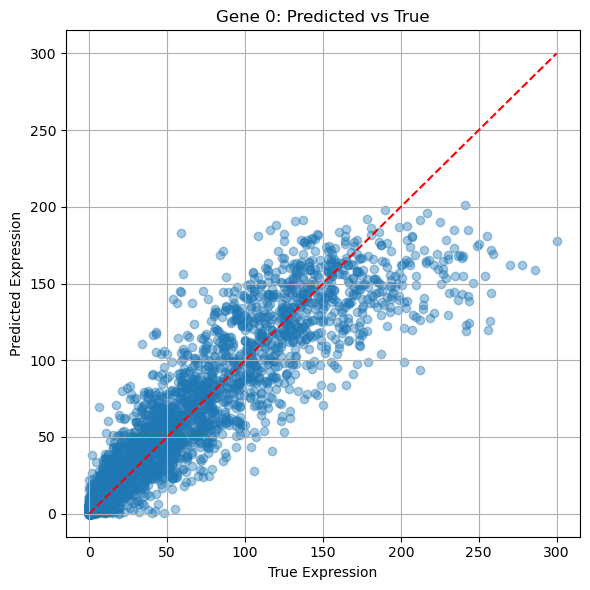

In [44]:
import matplotlib.pyplot as plt

gene_idx = 0

plt.figure(figsize=(6,6))
plt.scatter(expr[:, gene_idx], final_preds[:, gene_idx], alpha=0.4)
plt.plot([0, max(expr[:, gene_idx])], [0, max(expr[:, gene_idx])], 'r--')
plt.xlabel("True Expression")
plt.ylabel("Predicted Expression")
plt.title(f"Gene {gene_idx}: Predicted vs True")
plt.grid(True)
plt.tight_layout()
plt.show()


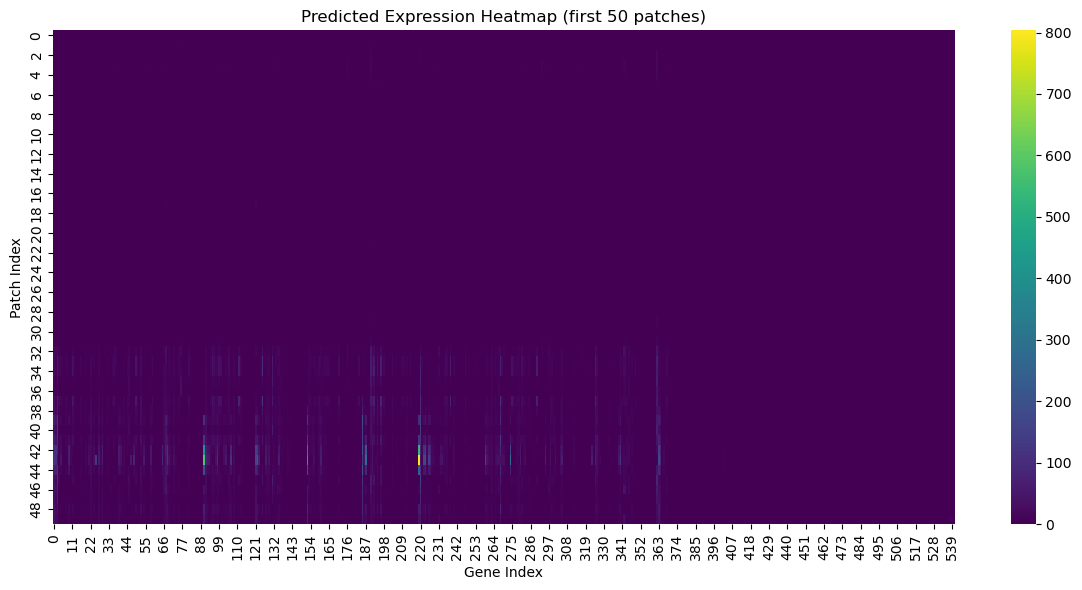

In [45]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(final_preds[:50], cmap="viridis")  # showing first 50 patches
plt.xlabel("Gene Index")
plt.ylabel("Patch Index")
plt.title("Predicted Expression Heatmap (first 50 patches)")
plt.tight_layout()
plt.show()


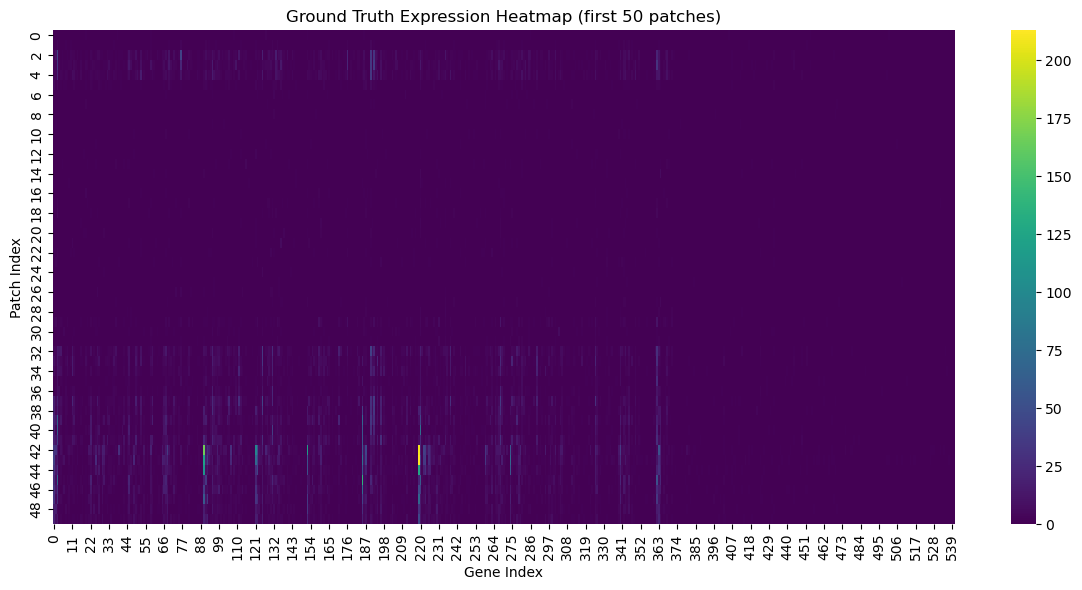

In [46]:
plt.figure(figsize=(12,6))
sns.heatmap(expr[:50], cmap="viridis")
plt.xlabel("Gene Index")
plt.ylabel("Patch Index")
plt.title("Ground Truth Expression Heatmap (first 50 patches)")
plt.tight_layout()
plt.show()


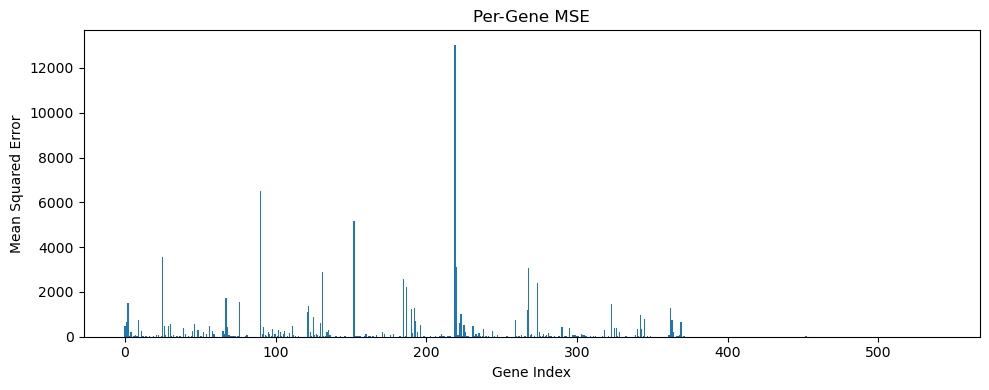

In [47]:
errors = final_preds - expr
mse_per_gene = np.mean(errors**2, axis=0)

plt.figure(figsize=(10,4))
plt.bar(range(len(mse_per_gene)), mse_per_gene)
plt.xlabel("Gene Index")
plt.ylabel("Mean Squared Error")
plt.title("Per-Gene MSE")
plt.tight_layout()
plt.show()


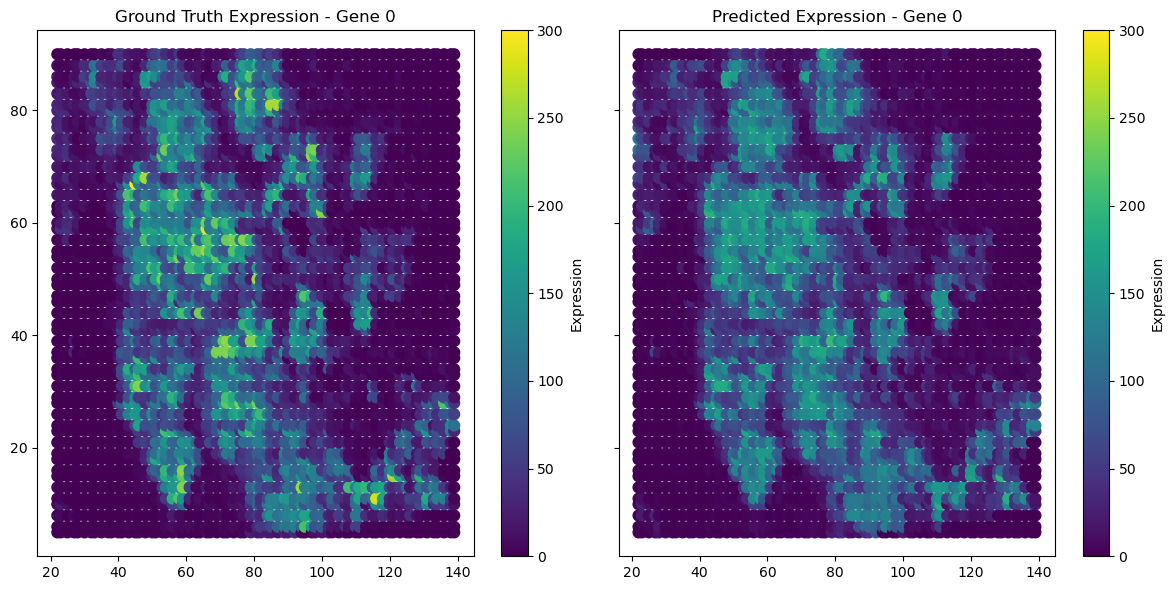

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 1. Load predictions
# -----------------------
preds = np.load("predicted_gene_expression.npy")

# -----------------------
# 2. Load metadata
# -----------------------
metadata = np.load("virchow_embeds/patch_to_expr_NCBI783_metadata.npy", allow_pickle=True)

# -----------------------
# 3. Load ground truth expression
# -----------------------
expr = np.stack([m[3] for m in metadata])

# -----------------------
# 4. Extract spatial coordinates
# -----------------------
coords = np.array([m[2] for m in metadata])  # shape: (N_patches, 2)
x_coords = coords[:,0]
y_coords = coords[:,1]

# -----------------------
# 5. Choose gene to plot
# -----------------------
gene_idx = 0   # Change to whichever gene you want

true_values = expr[:, gene_idx]
pred_values = preds[:, gene_idx]

# -----------------------
# 6. Determine shared color scale
# -----------------------
vmin = min(true_values.min(), pred_values.min())
vmax = max(true_values.max(), pred_values.max())

# -----------------------
# 7. Plot side-by-side
# -----------------------
fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

# Ground truth
sc0 = axes[0].scatter(x_coords, y_coords, c=true_values, cmap="viridis", vmin=vmin, vmax=vmax, s=60)
axes[0].set_title(f"Ground Truth Expression - Gene {gene_idx}")
axes[0].invert_yaxis()
plt.colorbar(sc0, ax=axes[0], label="Expression")

# Prediction
sc1 = axes[1].scatter(x_coords, y_coords, c=pred_values, cmap="viridis", vmin=vmin, vmax=vmax, s=60)
axes[1].set_title(f"Predicted Expression - Gene {gene_idx}")
axes[1].invert_yaxis()
plt.colorbar(sc1, ax=axes[1], label="Expression")

plt.tight_layout()
plt.show()


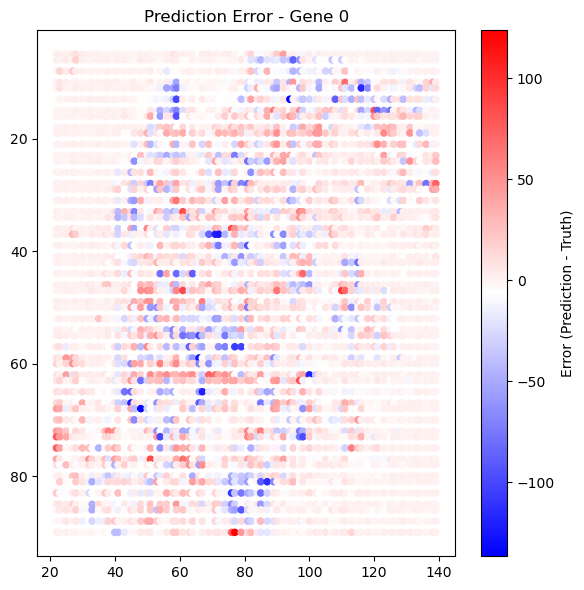

In [52]:
error = pred_values - true_values
plt.figure(figsize=(6,6))
plt.scatter(x_coords, y_coords, c=error, cmap="bwr", s=20)
plt.title(f"Prediction Error - Gene {gene_idx}")
plt.colorbar(label="Error (Prediction - Truth)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


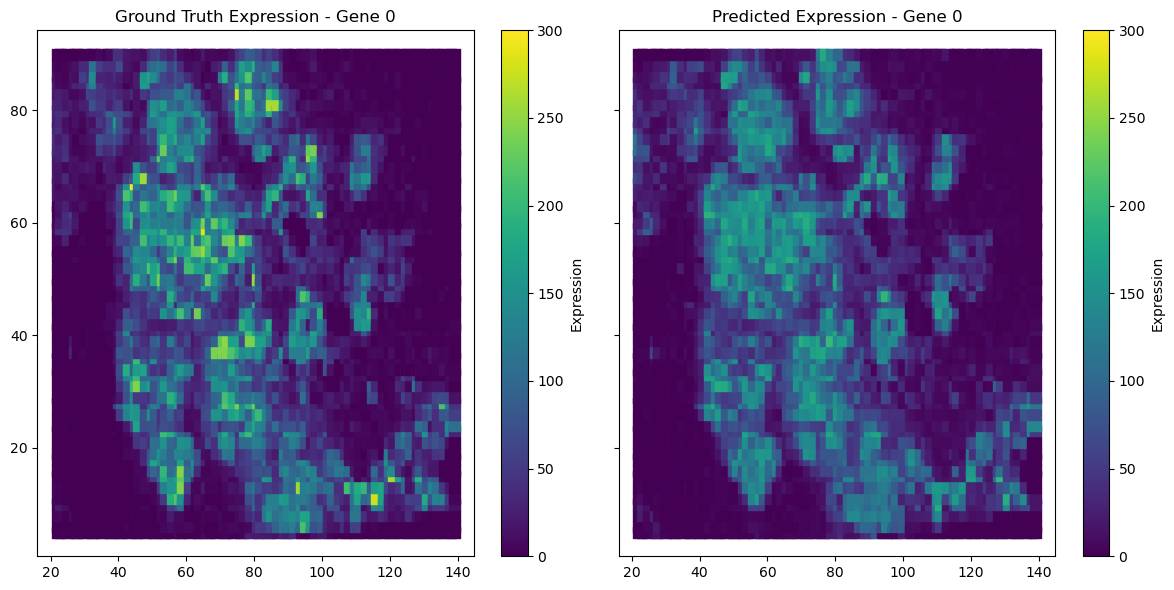

In [54]:
fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

# Ground truth
sc0 = axes[0].scatter(
    x_coords, y_coords,
    c=true_values,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    s=60,
    marker='s'  # 👈 square marker
)
axes[0].set_title(f"Ground Truth Expression - Gene {gene_idx}")
axes[0].invert_yaxis()
plt.colorbar(sc0, ax=axes[0], label="Expression")

# Prediction
sc1 = axes[1].scatter(
    x_coords, y_coords,
    c=pred_values,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    s=60,
    marker='s'  # 👈 square marker
)
axes[1].set_title(f"Predicted Expression - Gene {gene_idx}")
axes[1].invert_yaxis()
plt.colorbar(sc1, ax=axes[1], label="Expression")

plt.tight_layout()
plt.show()
